In [20]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Lists to store metrics and other results
# X_holdout = pd.read_csv('path_to_holdout_features.csv')  # replace with actual path?
matrix= pd.read_csv('/home/bram/bramenv/aa_test_2 matrix/test_set_final.csv')

# Extract the 'BDSPPatientID' and 'annot' columns to create y_data_pre
y_data_pre = matrix[['BDSPPatientID', 'annot']]
y_holdout = y_data_pre['annot']
X_holdout = matrix.drop(['BDSPPatientID', 'annot','CreateDate', 'hospital'], axis=1)


In [22]:
# Lists to store metrics and other results
auc_holdout = []
f1_holdout = []
precision_holdout = []
recall_holdout = []
auc_pr_holdout = []
cf_holdout = []
holdout_predictions = []
roc_curves_holdout = []
pr_curves_holdout = []
patient_ids = y_data_pre['BDSPPatientID']

In [23]:
# Lists to store false positive and false negative patient IDs
false_positives = []
false_negatives = []

In [24]:
# Dictionary to store feature importances
feature_importances_dict = {feature: [] for feature in X_holdout.columns}

In [25]:


y_pred_proba = 0
y_pred = 0

for fold in range(10):
    model_filename = f'/home/bram/bramenv/aa_test_2 matrix/model_RF/model_train_allhospitals_Notes+ICD+Med_fold{fold+1}.pickle'  # Updated path
    with open(model_filename, 'rb') as f:
        res = pickle.load(f)
    model = res['model']
    cutoff = res['cutoff']
    
    # Store patient IDs
   
    
   
    yp =  model.predict_proba(X_holdout)[:, 1]

    # for probability output, we take average as the final probability
    y_pred_proba += yp
    
    # for binary output (yes/no), we binarize within each fold, and then take majority vote across folds to get final binary output
    y_pred += (yp>cutoff).astype(int)

y_pred_proba /= 10
y_pred_bin = (y_pred>5).astype(int)

fpr, tpr, cutoffs = roc_curve(y_holdout, y_pred_proba)

auc_holdout=roc_auc_score(y_holdout, y_pred_proba)
f1_holdout=f1_score(y_holdout, y_pred_bin)
precision_holdout=precision_score(y_holdout, y_pred_bin)
recall_holdout=recall_score(y_holdout, y_pred_bin)
accuracy_holdout = accuracy_score(y_holdout, y_pred_bin)

precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_proba)
auc_pr = auc(recall, precision)
# auc_pr_holdout.append(auc_pr)

cf_holdout=confusion_matrix(y_holdout, y_pred_bin)
holdout_predictions=y_pred_bin

roc_curves_holdout.append((fpr, tpr, roc_auc_score(y_holdout, y_pred_proba)))
pr_curves_holdout.append((recall, precision, auc_pr))

# Identify false positives and false negatives
false_positive_ids = patient_ids[(y_holdout == 0) & (y_pred_bin == 1)]
false_negative_ids = patient_ids[(y_holdout == 1) & (y_pred_bin == 0)]
false_positives.append(false_positive_ids)
false_negatives.append(false_negative_ids)




In [26]:
print(y_pred_bin)
print(y_pred_proba)
print(len(y_pred_bin))
print(len(y_pred_proba))

[0 1 0 ... 0 0 1]
[0.02802446 0.84234333 0.02965659 ... 0.02029139 0.01773929 0.83841182]
1913
1913


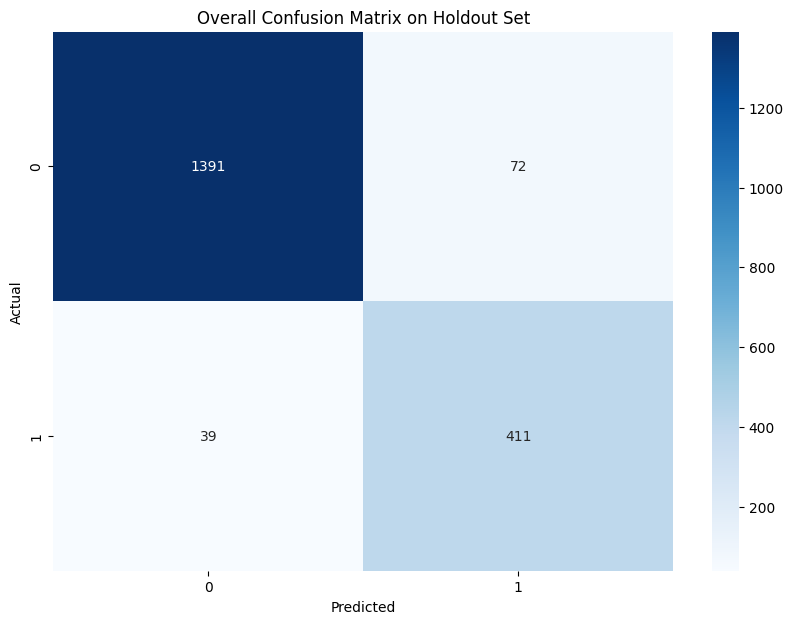

In [27]:
plt.figure(figsize=(10, 7))
sns.heatmap(cf_holdout, annot=True, fmt='d', cmap='Blues')
plt.title('Overall Confusion Matrix on Holdout Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('overall_confusion_matrix_holdout.png')
plt.show()

In [28]:
def calculate_metrics(cf_matrix):
    TN, FP, FN, TP = cf_matrix.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1

Overall Metrics on Holdout Set:
Accuracy: 0.9420
Precision: 0.8509
Recall: 0.9133
F1 Score: 0.8810


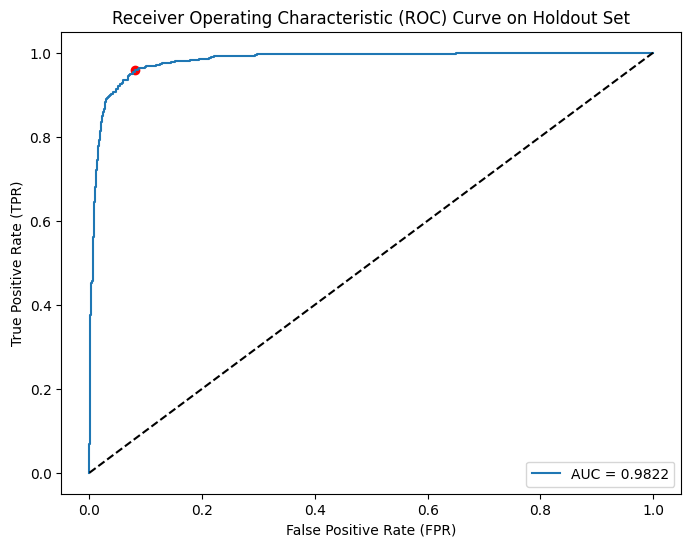

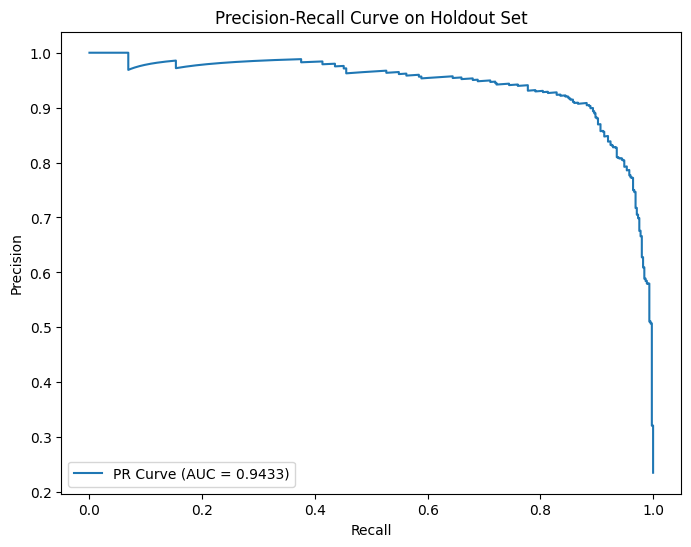

In [29]:
# Calculate overall metrics on the holdout set
overall_accuracy_holdout, overall_precision_holdout, overall_recall_holdout, overall_f1_holdout = calculate_metrics(cf_holdout)
print("Overall Metrics on Holdout Set:")
print(f"Accuracy: {overall_accuracy_holdout:.4f}")
print(f"Precision: {overall_precision_holdout:.4f}")
print(f"Recall: {overall_recall_holdout:.4f}")
print(f"F1 Score: {overall_f1_holdout:.4f}")

# Plot all ROC curves overlayed on a single graph for holdout set
plt.figure(figsize=(8, 6))
for fpr, tpr, auc_score in roc_curves_holdout:
    plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_score))
    # youden = np.max(tpr - fpr)
    plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], c='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve on Holdout Set')
plt.legend(loc='lower right')
plt.savefig('AUC_holdout.png')
plt.show()

# Plot all PR curves overlayed on a single graph for holdout set
plt.figure(figsize=(8, 6))
for recall, precision, auc_pr_loop in pr_curves_holdout:
    plt.plot(recall, precision, label='PR Curve (AUC = {:.4f})'.format(auc_pr_loop))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Holdout Set')
plt.legend(loc='lower left')
plt.savefig('PR_holdout.png')
plt.show()

# Create a DataFrame to hold the results
results_holdout_df = pd.DataFrame({
    'BDSPPatientID': y_data_pre['BDSPPatientID'],
    'true_label': y_holdout,
    'prediction': y_pred_proba,
    'prediction binary': y_pred_bin
})


In [30]:
# Save the DataFrame to a CSV file
results_holdout_df.to_csv('LR_holdout_pred.csv', index=False)

# Save false positives and false negatives to CSV files
false_positives_df = pd.DataFrame({'Fold': np.repeat(range(1), [len(fp) for fp in false_positives]), 'BDSPPatientID': np.concatenate(false_positives)})
false_negatives_df = pd.DataFrame({'Fold': np.repeat(range(1), [len(fn) for fn in false_negatives]), 'BDSPPatientID': np.concatenate(false_negatives)})

false_positives_df.to_csv('false_positives.csv', index=False)
false_negatives_df.to_csv('false_negatives.csv', index=False)


In [31]:
def bootstrap_resample(y_true, y_pred_proba, y_pred_bin, n_iterations=1000, alpha=0.95):
    aucs = []
    f1s = []
    precisions = []
    recalls = []
    accuracies = []
    auc_prs = []
    roc_curves = []
    pr_curves = []
    
    n_size = len(y_true)
    
    for _ in range(n_iterations):
        indices = np.random.randint(0, n_size, n_size)
        if len(np.unique(y_true[indices])) < 2:
            continue  # skip this resample if it does not have both classes
        
        aucs.append(roc_auc_score(y_true[indices], y_pred_proba[indices]))
        f1s.append(f1_score(y_true[indices], y_pred_bin[indices]))
        precisions.append(precision_score(y_true[indices], y_pred_bin[indices]))
        recalls.append(recall_score(y_true[indices], y_pred_bin[indices]))
        accuracies.append(accuracy_score(y_true[indices], y_pred_bin[indices]))
        
        precision, recall, _ = precision_recall_curve(y_true[indices], y_pred_proba[indices])
        auc_prs.append(auc(recall, precision))
        
        fpr, tpr, _ = roc_curve(y_true[indices], y_pred_proba[indices])
        roc_curves.append((fpr, tpr))
        
        pr_curves.append((precision, recall))
    
    # Calculate confidence intervals
    lower_p = ((1.0 - alpha) / 2.0) * 100
    upper_p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    
    auc_ci = np.percentile(aucs, [lower_p, upper_p])
    f1_ci = np.percentile(f1s, [lower_p, upper_p])
    precision_ci = np.percentile(precisions, [lower_p, upper_p])
    recall_ci = np.percentile(recalls, [lower_p, upper_p])
    accuracy_ci = np.percentile(accuracies, [lower_p, upper_p])
    auc_pr_ci = np.percentile(auc_prs, [lower_p, upper_p])
    
    return auc_ci, f1_ci, precision_ci, recall_ci, accuracy_ci, auc_pr_ci, roc_curves, pr_curves

# Perform bootstrap resampling to get confidence intervals
auc_ci, f1_ci, precision_ci, recall_ci, accuracy_ci, auc_pr_ci, roc_curves_bootstrap, pr_curves_bootstrap = bootstrap_resample(y_holdout, y_pred_proba, y_pred_bin)

# Print metrics and confidence intervals
print("Metrics on Holdout Set:")
print(f"AUC: {auc_holdout:.4f} (95% CI: {auc_ci[0]:.4f} - {auc_ci[1]:.4f})")
print(f"F1 Score: {f1_holdout:.4f} (95% CI: {f1_ci[0]:.4f} - {f1_ci[1]:.4f})")
print(f"Precision: {precision_holdout:.4f} (95% CI: {precision_ci[0]:.4f} - {precision_ci[1]:.4f})")
print(f"Recall: {recall_holdout:.4f} (95% CI: {recall_ci[0]:.4f} - {recall_ci[1]:.4f})")
print(f"Accuracy: {accuracy_holdout:.4f} (95% CI: {accuracy_ci[0]:.4f} - {accuracy_ci[1]:.4f})")
print(f"AUC-PR: {auc_pr:.4f} (95% CI: {auc_pr_ci[0]:.4f} - {auc_pr_ci[1]:.4f})")

Metrics on Holdout Set:
AUC: 0.9822 (95% CI: 0.9768 - 0.9873)
F1 Score: 0.8810 (95% CI: 0.8584 - 0.9025)
Precision: 0.8509 (95% CI: 0.8178 - 0.8833)
Recall: 0.9133 (95% CI: 0.8873 - 0.9374)
Accuracy: 0.9420 (95% CI: 0.9315 - 0.9524)
AUC-PR: 0.9433 (95% CI: 0.9217 - 0.9615)


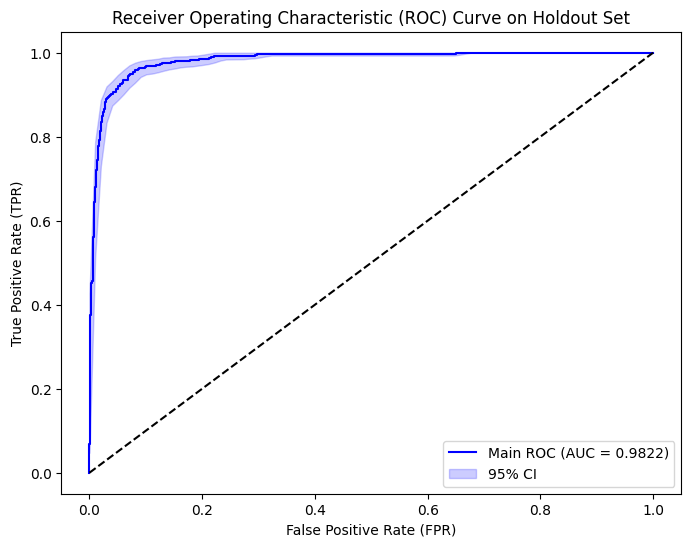

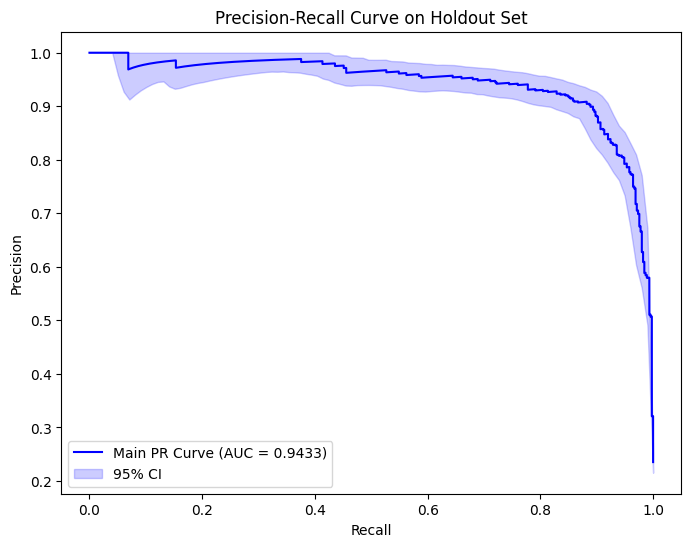

In [32]:
def calculate_confidence_intervals(curves, n_bins=100):
    mean_curve = np.linspace(0, 1, n_bins)
    interpolated_curves = [np.interp(mean_curve, curve[0], curve[1]) for curve in curves]
    lower_ci = np.percentile(interpolated_curves, 2.5, axis=0)
    upper_ci = np.percentile(interpolated_curves, 97.5, axis=0)
    mean_curve = np.mean(interpolated_curves, axis=0)
    return mean_curve, lower_ci, upper_ci

# Calculate confidence intervals for ROC
roc_fpr_interp = np.linspace(0, 1, 100)
roc_tpr_interp = [np.interp(roc_fpr_interp, fpr, tpr) for fpr, tpr in roc_curves_bootstrap]
roc_mean_tpr = np.mean(roc_tpr_interp, axis=0)
roc_lower_tpr = np.percentile(roc_tpr_interp, 2.5, axis=0)
roc_upper_tpr = np.percentile(roc_tpr_interp, 97.5, axis=0)

# Calculate confidence intervals for PR
pr_recall_interp = np.linspace(0, 1, 100)
pr_precision_interp = [np.interp(pr_recall_interp, recall[::-1], precision[::-1]) for precision, recall in pr_curves_bootstrap]
pr_mean_precision = np.mean(pr_precision_interp, axis=0)
pr_lower_precision = np.percentile(pr_precision_interp, 2.5, axis=0)
pr_upper_precision = np.percentile(pr_precision_interp, 97.5, axis=0)

# Plot ROC curve with confidence intervals
plt.figure(figsize=(8, 6))
plt.plot(roc_curves_holdout[0][0], roc_curves_holdout[0][1], label=f'Main ROC (AUC = {roc_curves_holdout[0][2]:.4f})', color='blue')
plt.fill_between(roc_fpr_interp, roc_lower_tpr, roc_upper_tpr, color='blue', alpha=0.2, label='95% CI')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve on Holdout Set')
plt.legend(loc='lower right')
plt.savefig('AUC_holdout.png')
plt.show()

# Plot PR curve with confidence intervals
plt.figure(figsize=(8, 6))
plt.plot(pr_curves_holdout[0][0], pr_curves_holdout[0][1], label=f'Main PR Curve (AUC = {pr_curves_holdout[0][2]:.4f})', color='blue')
plt.fill_between(pr_recall_interp, pr_lower_precision, pr_upper_precision, color='blue', alpha=0.2, label='95% CI')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Holdout Set')
plt.legend(loc='lower left')
plt.savefig('PR_holdout.png')
plt.show()

# Save all the data
df_holdout = pd.DataFrame({
    'metric': ['auc', 'f1', 'precision', 'recall', 'accuracy', 'auc_pr'],
    'value': [auc_holdout, f1_holdout, precision_holdout, recall_holdout, accuracy_holdout, auc_pr],
    'ci_lower': [auc_ci[0], f1_ci[0], precision_ci[0], recall_ci[0], accuracy_ci[0], auc_pr_ci[0]],
    'ci_upper': [auc_ci[1], f1_ci[1], precision_ci[1], recall_ci[1], accuracy_ci[1], auc_pr_ci[1]]
})
df_holdout.to_csv('LR_holdout_metrics.csv', index=False)

SyntaxError: invalid character '’' (U+2019) (61797184.py, line 174)